# Classifier

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Rest of the code...

## Load index csv

In [3]:
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

dataset_size = dataset_index.shape[0]
num_classes = np.amax(dataset_index['label'])

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']

print('append path prefix')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

# subtract label id by 1
dataset_index['label'] -= 1

print('subtract label id by 1')
print(dataset_index.shape)
print(dataset_index.head())
print('\n')

# train-test split
train_index = dataset_index.sample(frac=0.8)  # 80% train
train_size = train_index.shape[0]
test_index = dataset_index.drop(train_index.index)
test_size = test_index.shape[0]

print('Train')
print(train_index.shape)
print(train_index.head())
print('\n')
print('Test')
print(test_index.shape)
print(test_index.head())



(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east


append path prefix
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg


subtract label id by 1
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     37  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     25  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      8        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     35  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5

## Create datasets, preprocessing

train size: 4024
test size 126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


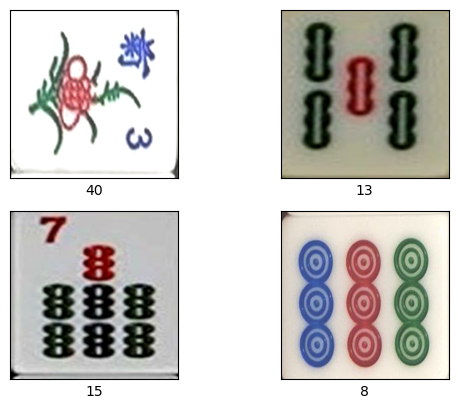

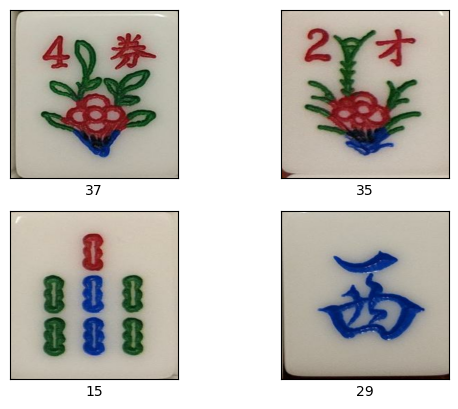

In [4]:
def show_image_sample(ds):
    for n, (image, label) in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(np.argmax(label))
    plt.show()

def read_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [320, 320])
    image /= 255.0  # normalize to [0,1]
    return image

def rotate_image(image, label):
    image = tf.image.rot90(image)
    return image, label

def augment(image, label):
    # Rotate the image randomly by 90, 180, or 270 degrees
    k = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    
    # Apply random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.2)
    
    return image, label

def get_dataset(dataset_index):
    
    path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
    image_ds = path_ds.map(read_image, num_parallel_calls=AUTOTUNE)
    
    label_one_hot = tf.one_hot(dataset_index['label'], num_classes)
    label_ds = tf.data.Dataset.from_tensor_slices(label_one_hot)
    
    paired_ds = tf.data.Dataset.zip((image_ds, label_ds))

    return paired_ds




train_ds = get_dataset(train_index)
train_ds = train_ds.map(augment).concatenate(train_ds)
train_ds = train_ds.map(augment).concatenate(train_ds)
train_ds = train_ds.map(augment).concatenate(train_ds)

train_size = train_ds.cardinality().numpy()
print('train size:', train_size)

test_ds = get_dataset(test_index)
print('test size', test_size)



show_image_sample(train_ds)
show_image_sample(test_ds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


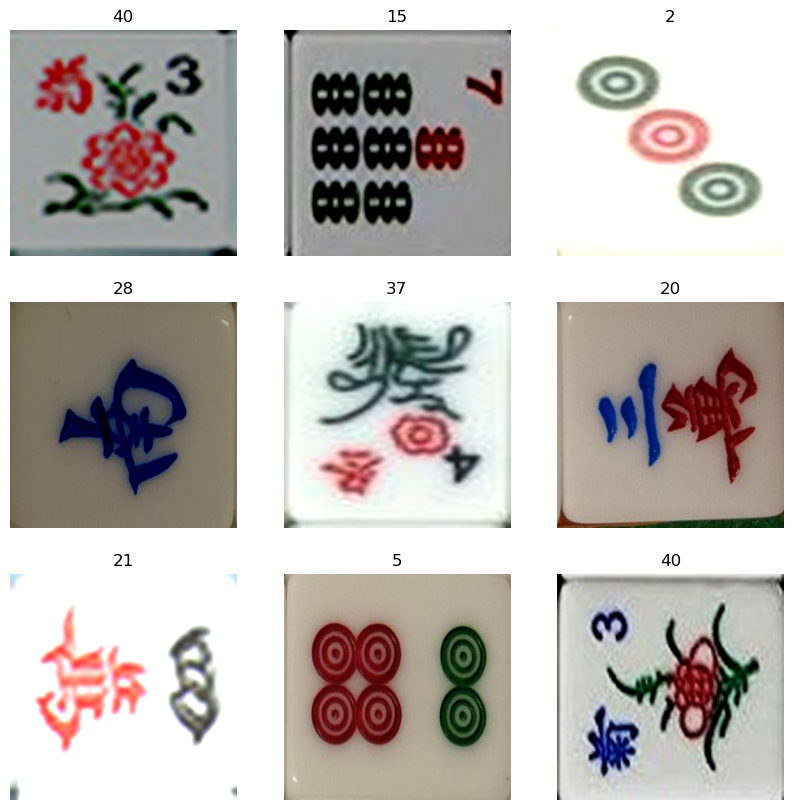

In [5]:
import random

# Function to show random images with labels
def show_random_images_with_labels(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    dataset = dataset.shuffle(buffer_size=num_images)  # Shuffle the dataset
    dataset = dataset.take(num_images)  # Take a random sample of images
    
    images = []
    labels = []
    for image, label in dataset:
        images.append(image)
        labels.append(np.argmax(label))
    
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")
    plt.show()

show_random_images_with_labels(train_ds)

## Train classifier model

In [7]:
import tensorflow as tf
from tensorflow import keras

# Define your model
model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(320, 320, 3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

# Train the model with the TensorBoard callback
history = model.fit(train_ds.batch(32),
                    epochs=10,
                    validation_data=test_ds.batch(32),
                    callbacks=[tensorboard_callback])

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds.batch(32))

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Epoch 1/10
126/126 [==============================] - 263s 2s/step - loss: 3.5674 - accuracy: 0.3181 - val_loss: 1.5196 - val_accuracy: 0.6032
Epoch 2/10
126/126 [==============================] - 214s 2s/step - loss: 0.6137 - accuracy: 0.8452 - val_loss: 1.4796 - val_accuracy: 0.6429
Epoch 3/10
126/126 [==============================] - 212s 2s/step - loss: 0.2005 - accuracy: 0.9548 - val_loss: 1.8685 - val_accuracy: 0.5952
Epoch 4/10
126/126 [==============================] - 213s 2s/step - loss: 0.0540 - accuracy: 0.9873 - val_loss: 2.0146 - val_accuracy: 0.6349
Epoch 5/10
126/126 [==============================] - 205s 2s/step - loss: 0.0173 - accuracy: 0.9963 - val_loss: 2.0454 - val_accuracy: 0.6587
Epoch 6/10
126/126 [==============================] - 220s 2s/step - loss: 0.0321 - accuracy: 0.9940 - val_loss: 2.2444 - val_accuracy: 0.6190
Epoch 7/10
126/126 [==============================] - 230s 2s/step - loss: 0.0146 - accuracy: 0.9965 - val_loss: 2.4241 - val_accuracy: 0.6587

In [103]:
# test_ds_batch = test_ds.cache()\
#     .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=test_size))\
#     .batch(batch_size)\
#     .prefetch(buffer_size=AUTOTUNE)

# classifier.evaluate(test_ds_batch, steps=int(test_size/batch_size))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 159, 159, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 78, 78, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 389376)            0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [147]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds.batch(32))

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 [==============================] - 2s 458ms/step - loss: 1.6547 - accuracy: 0.6349
Test Loss: 1.6546869277954102
Test Accuracy: 0.6349206566810608


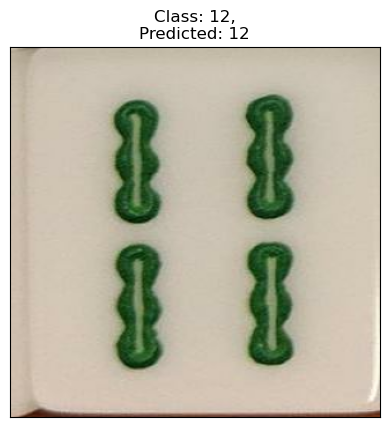

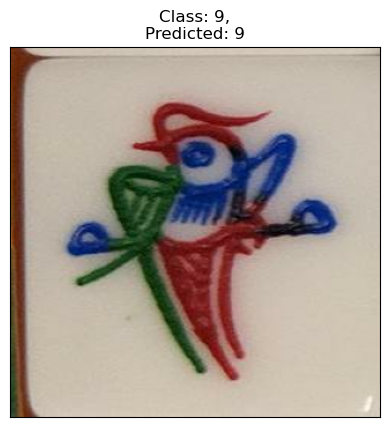

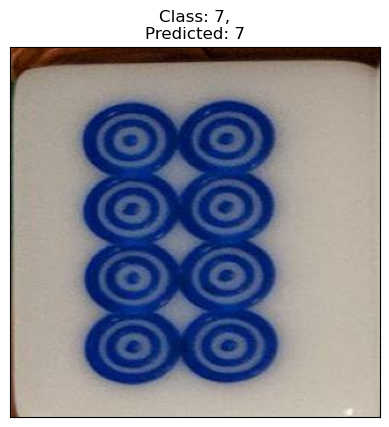

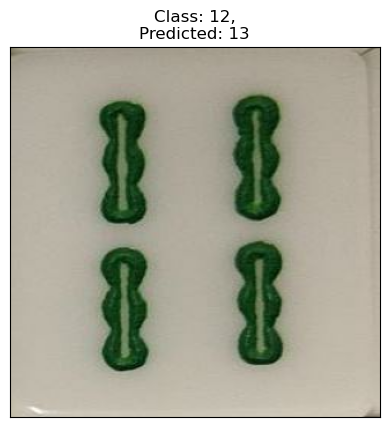

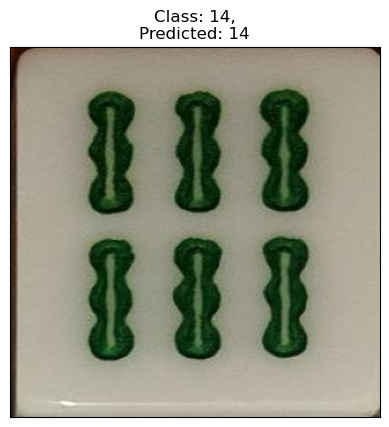

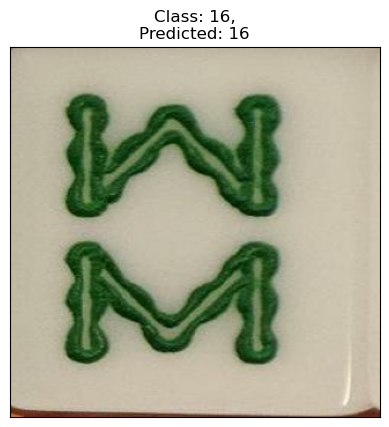

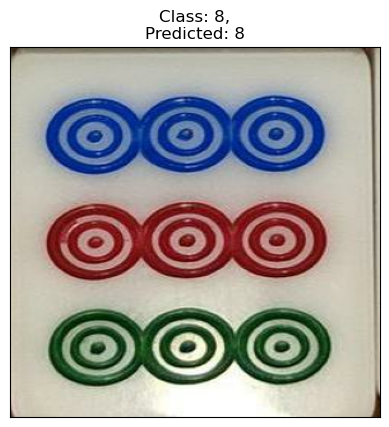

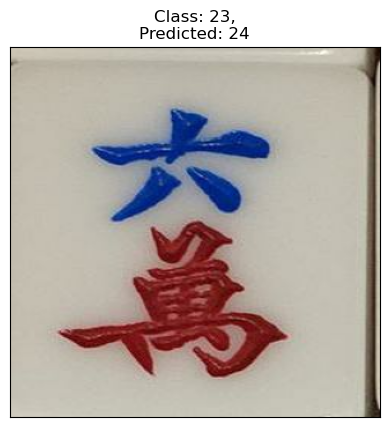

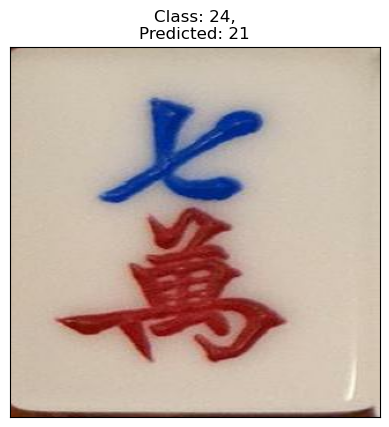

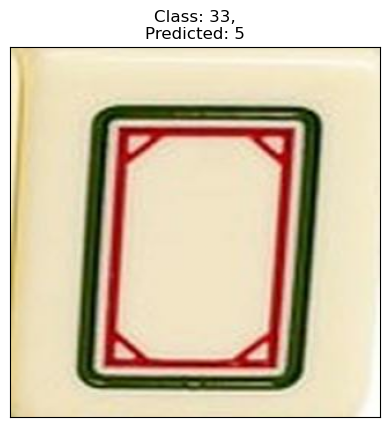

In [102]:
for n, (image, label) in enumerate(test_ds.skip(10).take(10)):
    pred = model.predict_on_batch(x=image[np.newaxis,:])[0]
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title("Class: {},\nPredicted: {}".format(np.argmax(label), np.argmax(pred)))
    plt.show()

In [ ]:
!tensorboard --logdir=logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.2 at http://localhost:6007/ (Press CTRL+C to quit)
